In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset,DataLoader
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import time
import copy
import numpy as np
import torch.nn.utils.prune as prune
from prettytable import PrettyTable
import sklearn.metrics
import argparse
import tqdm as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numbers
from abc import ABC, abstractmethod
from collections.abc import Iterable
from typing import Tuple

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Custom Pruning Method Helper Functions**

In [3]:
class BasePruningMethod(ABC):
    r"""Abstract base class for creation of new pruning techniques.

    Provides a skeleton for customization requiring the overriding of methods
    such as :meth:`compute_mask` and :meth:`apply`.
    """

    _tensor_name: str

    def __call__(self, module, inputs):
        r"""Multiply the mask into original tensor and store the result.

        Multiplies the mask (stored in ``module[name + '_mask']``)
        into the original tensor (stored in ``module[name + '_orig']``)
        and stores the result into ``module[name]`` by using :meth:`apply_mask`.

        Args:
            module (nn.Module): module containing the tensor to prune
            inputs: not used.
        """
        setattr(module, self._tensor_name, self.apply_mask(module))

    @abstractmethod
    def compute_mask(self, t, default_mask):
        r"""Compute and returns a mask for the input tensor ``t``.

        Starting from a base ``default_mask`` (which should be a mask of ones
        if the tensor has not been pruned yet), generate a random mask to
        apply on top of the ``default_mask`` according to the specific pruning
        method recipe.

        Args:
            t (torch.Tensor): tensor representing the importance scores of the
            parameter to prune.
            default_mask (torch.Tensor): Base mask from previous pruning
            iterations, that need to be respected after the new mask is
            applied. Same dims as ``t``.

        Returns:
            mask (torch.Tensor): mask to apply to ``t``, of same dims as ``t``
        """
        pass

    def apply_mask(self, module):
        r"""Simply handles the multiplication between the parameter being pruned and the generated mask.

        Fetches the mask and the original tensor from the module
        and returns the pruned version of the tensor.

        Args:
            module (nn.Module): module containing the tensor to prune

        Returns:
            pruned_tensor (torch.Tensor): pruned version of the input tensor
        """
        # to carry out the multiplication, the mask needs to have been computed,
        # so the pruning method must know what tensor it's operating on
        assert self._tensor_name is not None, f"Module {module} has to be pruned"  # this gets set in apply()
        mask = getattr(module, self._tensor_name + "_mask")
        orig = getattr(module, self._tensor_name + "_orig")
        pruned_tensor = mask.to(dtype=orig.dtype) * orig
        return pruned_tensor

    @classmethod
    def apply(cls, module, name, *args, importance_scores=None, **kwargs):
        r"""Add pruning on the fly and reparametrization of a tensor.

        Adds the forward pre-hook that enables pruning on the fly and
        the reparametrization of a tensor in terms of the original tensor
        and the pruning mask.

        Args:
            module (nn.Module): module containing the tensor to prune
            name (str): parameter name within ``module`` on which pruning
                will act.
            args: arguments passed on to a subclass of
                :class:`BasePruningMethod`
            importance_scores (torch.Tensor): tensor of importance scores (of
                same shape as module parameter) used to compute mask for pruning.
                The values in this tensor indicate the importance of the
                corresponding elements in the parameter being pruned.
                If unspecified or None, the parameter will be used in its place.
            kwargs: keyword arguments passed on to a subclass of a
                :class:`BasePruningMethod`
        """

        def _get_composite_method(cls, module, name, *args, **kwargs):
            # Check if a pruning method has already been applied to
            # `module[name]`. If so, store that in `old_method`.
            old_method = None
            found = 0
            # there should technically be only 1 hook with hook.name == name
            # assert this using `found`
            hooks_to_remove = []
            for k, hook in module._forward_pre_hooks.items():
                # if it exists, take existing thing, remove hook, then
                # go through normal thing
                if isinstance(hook, BasePruningMethod) and hook._tensor_name == name:
                    old_method = hook
                    hooks_to_remove.append(k)
                    found += 1
            assert (
                found <= 1
            ), f"Avoid adding multiple pruning hooks to the\
                same tensor {name} of module {module}. Use a PruningContainer."

            for k in hooks_to_remove:
                del module._forward_pre_hooks[k]

            # Apply the new pruning method, either from scratch or on top of
            # the previous one.
            method = cls(*args, **kwargs)  # new pruning
            # Have the pruning method remember what tensor it's been applied to
            method._tensor_name = name

            # combine `methods` with `old_method`, if `old_method` exists
            if old_method is not None:  # meaning that there was a hook
                # if the hook is already a pruning container, just add the
                # new pruning method to the container
                if isinstance(old_method, PruningContainer):
                    old_method.add_pruning_method(method)
                    method = old_method  # rename old_method --> method

                # if the hook is simply a single pruning method, create a
                # container, add the old pruning method and the new one
                elif isinstance(old_method, BasePruningMethod):
                    container = PruningContainer(old_method)
                    # Have the pruning method remember the name of its tensor
                    # setattr(container, '_tensor_name', name)
                    container.add_pruning_method(method)
                    method = container  # rename container --> method
            return method

        method = _get_composite_method(cls, module, name, *args, **kwargs)
        # at this point we have no forward_pre_hooks but we could have an
        # active reparametrization of the tensor if another pruning method
        # had been applied (in which case `method` would be a PruningContainer
        # and not a simple pruning method).

        # Pruning is to be applied to the module's tensor named `name`,
        # starting from the state it is found in prior to this iteration of
        # pruning. The pruning mask is calculated based on importances scores.

        orig = getattr(module, name)
        if importance_scores is not None:
            assert (
                importance_scores.shape == orig.shape
            ), f"importance_scores should have the same shape as parameter                 {name} of {module}"
        else:
            importance_scores = orig

        # If this is the first time pruning is applied, take care of moving
        # the original tensor to a new parameter called name + '_orig' and
        # and deleting the original parameter
        if not isinstance(method, PruningContainer):
            # copy `module[name]` to `module[name + '_orig']`
            module.register_parameter(name + "_orig", orig)
            # temporarily delete `module[name]`
            del module._parameters[name]
            default_mask = torch.ones_like(orig)  # temp
        # If this is not the first time pruning is applied, all of the above
        # has been done before in a previous pruning iteration, so we're good
        # to go
        else:
            default_mask = (
                getattr(module, name + "_mask")
                .detach()
                .clone(memory_format=torch.contiguous_format)
            )

        # Use try/except because if anything goes wrong with the mask
        # computation etc., you'd want to roll back.
        try:
            # get the final mask, computed according to the specific method
            mask = method.compute_mask(importance_scores, default_mask=default_mask)
            # reparameterize by saving mask to `module[name + '_mask']`...
            module.register_buffer(name + "_mask", mask)
            # ... and the new pruned tensor to `module[name]`
            setattr(module, name, method.apply_mask(module))
            # associate the pruning method to the module via a hook to
            # compute the function before every forward() (compile by run)
            module.register_forward_pre_hook(method)

        except Exception as e:
            if not isinstance(method, PruningContainer):
                orig = getattr(module, name + "_orig")
                module.register_parameter(name, orig)
                del module._parameters[name + "_orig"]
            raise e

        return method

    def prune(self, t, default_mask=None, importance_scores=None):
        r"""Compute and returns a pruned version of input tensor ``t``.

        According to the pruning rule specified in :meth:`compute_mask`.

        Args:
            t (torch.Tensor): tensor to prune (of same dimensions as
                ``default_mask``).
            importance_scores (torch.Tensor): tensor of importance scores (of
                same shape as ``t``) used to compute mask for pruning ``t``.
                The values in this tensor indicate the importance of the
                corresponding elements in the ``t`` that is being pruned.
                If unspecified or None, the tensor ``t`` will be used in its place.
            default_mask (torch.Tensor, optional): mask from previous pruning
                iteration, if any. To be considered when determining what
                portion of the tensor that pruning should act on. If None,
                default to a mask of ones.

        Returns:
            pruned version of tensor ``t``.
        """
        if importance_scores is not None:
            assert (
                importance_scores.shape == t.shape
            ), "importance_scores should have the same shape as tensor t"
        else:
            importance_scores = t
        default_mask = default_mask if default_mask is not None else torch.ones_like(t)
        return t * self.compute_mask(importance_scores, default_mask=default_mask)

    def remove(self, module):
        r"""Remove the pruning reparameterization from a module.

        The pruned parameter named ``name`` remains permanently pruned,
        and the parameter named ``name+'_orig'`` is removed from the parameter list.
        Similarly, the buffer named ``name+'_mask'`` is removed from the buffers.

        Note:
            Pruning itself is NOT undone or reversed!
        """
        # before removing pruning from a tensor, it has to have been applied
        assert (
            self._tensor_name is not None
        ), f"Module {module} has to be pruned            before pruning can be removed"  # this gets set in apply()

        # to update module[name] to latest trained weights
        weight = self.apply_mask(module)  # masked weights

        # delete and reset
        if hasattr(module, self._tensor_name):
            delattr(module, self._tensor_name)
        orig = module._parameters[self._tensor_name + "_orig"]
        orig.data = weight.data
        del module._parameters[self._tensor_name + "_orig"]
        del module._buffers[self._tensor_name + "_mask"]
        setattr(module, self._tensor_name, orig)


class PruningContainer(BasePruningMethod):
    """Container holding a sequence of pruning methods for iterative pruning.

    Keeps track of the order in which pruning methods are applied and handles
    combining successive pruning calls.

    Accepts as argument an instance of a BasePruningMethod or an iterable of
    them.
    """

    def __init__(self, *args):
        self._pruning_methods: Tuple[BasePruningMethod, ...] = tuple()
        if not isinstance(args, Iterable):  # only 1 item
            self._tensor_name = args._tensor_name
            self.add_pruning_method(args)
        elif len(args) == 1:  # only 1 item in a tuple
            self._tensor_name = args[0]._tensor_name
            self.add_pruning_method(args[0])
        else:  # manual construction from list or other iterable (or no args)
            for method in args:
                self.add_pruning_method(method)

    def add_pruning_method(self, method):
        r"""Add a child pruning ``method`` to the container.

        Args:
            method (subclass of BasePruningMethod): child pruning method
                to be added to the container.
        """
        # check that we're adding a pruning method to the container
        if not isinstance(method, BasePruningMethod) and method is not None:
            raise TypeError(
                f"{type(method)} is not a BasePruningMethod subclass"
            )
        elif method is not None and self._tensor_name != method._tensor_name:
            raise ValueError(
                "Can only add pruning methods acting on "
                f"the parameter named '{self._tensor_name}' to PruningContainer {self}."
                + f" Found '{method._tensor_name}'"
            )
        # if all checks passed, add to _pruning_methods tuple
        self._pruning_methods += (method,)  # type: ignore[operator]

    def __len__(self):
        return len(self._pruning_methods)

    def __iter__(self):
        return iter(self._pruning_methods)

    def __getitem__(self, idx):
        return self._pruning_methods[idx]

    def compute_mask(self, t, default_mask):
        r"""Apply the latest ``method`` by computing the new partial masks and returning its combination with the ``default_mask``.

        The new partial mask should be computed on the entries or channels
        that were not zeroed out by the ``default_mask``.
        Which portions of the tensor ``t`` the new mask will be calculated from
        depends on the ``PRUNING_TYPE`` (handled by the type handler):

        * for 'unstructured', the mask will be computed from the raveled
          list of nonmasked entries;

        * for 'structured', the mask will be computed from the nonmasked
          channels in the tensor;

        * for 'global', the mask will be computed across all entries.

        Args:
            t (torch.Tensor): tensor representing the parameter to prune
                (of same dimensions as ``default_mask``).
            default_mask (torch.Tensor): mask from previous pruning iteration.

        Returns:
            mask (torch.Tensor): new mask that combines the effects
            of the ``default_mask`` and the new mask from the current
            pruning ``method`` (of same dimensions as ``default_mask`` and
            ``t``).
        """

        def _combine_masks(method, t, mask):
            r"""Combine the masks from all pruning methods and returns a new mask.

            Args:
                method (a BasePruningMethod subclass): pruning method
                    currently being applied.
                t (torch.Tensor): tensor representing the parameter to prune
                    (of same dimensions as mask).
                mask (torch.Tensor): mask from previous pruning iteration

            Returns:
                new_mask (torch.Tensor): new mask that combines the effects
                    of the old mask and the new mask from the current
                    pruning method (of same dimensions as mask and t).
            """
            new_mask = mask  # start off from existing mask
            new_mask = new_mask.to(dtype=t.dtype)

            # compute a slice of t onto which the new pruning method will operate
            if method.PRUNING_TYPE == "unstructured":
                # prune entries of t where the mask is 1
                slc = mask == 1

            # for struct pruning, exclude channels that have already been
            # entirely pruned
            elif method.PRUNING_TYPE == "structured":
                if not hasattr(method, "dim"):
                    raise AttributeError(
                        "Pruning methods of PRUNING_TYPE "
                        '"structured" need to have the attribute `dim` defined.'
                    )

                # find the channels to keep by removing the ones that have been
                # zeroed out already (i.e. where sum(entries) == 0)
                n_dims = t.dim()  # "is this a 2D tensor? 3D? ..."
                dim = method.dim
                # convert negative indexing
                if dim < 0:
                    dim = n_dims + dim
                # if dim is still negative after subtracting it from n_dims
                if dim < 0:
                    raise IndexError(
                        f"Index is out of bounds for tensor with dimensions {n_dims}"
                    )
                # find channels along dim = dim that aren't already tots 0ed out
                keep_channel = mask.sum(dim=[d for d in range(n_dims) if d != dim]) != 0
                # create slice to identify what to prune
                slc = [slice(None)] * n_dims
                slc[dim] = keep_channel

            elif method.PRUNING_TYPE == "global":
                n_dims = len(t.shape)  # "is this a 2D tensor? 3D? ..."
                slc = [slice(None)] * n_dims

            else:
                raise ValueError(
                    f"Unrecognized PRUNING_TYPE {method.PRUNING_TYPE}"
                )

            # compute the new mask on the unpruned slice of the tensor t
            partial_mask = method.compute_mask(t[slc], default_mask=mask[slc])
            new_mask[slc] = partial_mask.to(dtype=new_mask.dtype)

            return new_mask

        method = self._pruning_methods[-1]
        mask = _combine_masks(method, t, default_mask)
        return mask


class Identity(BasePruningMethod):
    r"""Utility pruning method that does not prune any units but generates the pruning parametrization with a mask of ones."""

    PRUNING_TYPE = "unstructured"

    def compute_mask(self, t, default_mask):
        mask = default_mask
        return mask

    @classmethod
    def apply(cls, module, name):
        r"""Add pruning on the fly and reparametrization of a tensor.

        Adds the forward pre-hook that enables pruning on the fly and
        the reparametrization of a tensor in terms of the original tensor
        and the pruning mask.

        Args:
            module (nn.Module): module containing the tensor to prune
            name (str): parameter name within ``module`` on which pruning
                will act.
        """
        return super().apply(module, name)


class RandomUnstructured(BasePruningMethod):
    r"""Prune (currently unpruned) units in a tensor at random.

    Args:
        name (str): parameter name within ``module`` on which pruning
            will act.
        amount (int or float): quantity of parameters to prune.
            If ``float``, should be between 0.0 and 1.0 and represent the
            fraction of parameters to prune. If ``int``, it represents the
            absolute number of parameters to prune.
    """

    PRUNING_TYPE = "unstructured"

    def __init__(self, amount):
        # Check range of validity of pruning amount
        _validate_pruning_amount_init(amount)
        self.amount = amount

    def compute_mask(self, t, default_mask):
        # Check that the amount of units to prune is not > than the number of
        # parameters in t
        tensor_size = t.nelement()
        # Compute number of units to prune: amount if int,
        # else amount * tensor_size
        nparams_toprune = _compute_nparams_toprune(self.amount, tensor_size)
        # This should raise an error if the number of units to prune is larger
        # than the number of units in the tensor
        _validate_pruning_amount(nparams_toprune, tensor_size)

        mask = default_mask.clone(memory_format=torch.contiguous_format)

        if nparams_toprune != 0:  # k=0 not supported by torch.kthvalue
            prob = torch.rand_like(t)
            topk = torch.topk(prob.view(-1), k=nparams_toprune)
            mask.view(-1)[topk.indices] = 0

        return mask

    @classmethod
    def apply(cls, module, name, amount):
        r"""Add pruning on the fly and reparametrization of a tensor.

        Adds the forward pre-hook that enables pruning on the fly and
        the reparametrization of a tensor in terms of the original tensor
        and the pruning mask.

        Args:
            module (nn.Module): module containing the tensor to prune
            name (str): parameter name within ``module`` on which pruning
                will act.
            amount (int or float): quantity of parameters to prune.
                If ``float``, should be between 0.0 and 1.0 and represent the
                fraction of parameters to prune. If ``int``, it represents the
                absolute number of parameters to prune.
        """
        return super().apply(module, name, amount=amount)


class L1Unstructured(BasePruningMethod):
    r"""Prune (currently unpruned) units in a tensor by zeroing out the ones with the lowest L1-norm.

    Args:
        amount (int or float): quantity of parameters to prune.
            If ``float``, should be between 0.0 and 1.0 and represent the
            fraction of parameters to prune. If ``int``, it represents the
            absolute number of parameters to prune.
    """

    PRUNING_TYPE = "unstructured"

    def __init__(self, amount):
        # Check range of validity of pruning amount
        _validate_pruning_amount_init(amount)
        self.amount = amount

    def compute_mask(self, t, default_mask):
        # Check that the amount of units to prune is not > than the number of
        # parameters in t
        tensor_size = t.nelement()
        # Compute number of units to prune: amount if int,
        # else amount * tensor_size
        nparams_toprune = _compute_nparams_toprune(self.amount, tensor_size)
        # This should raise an error if the number of units to prune is larger
        # than the number of units in the tensor
        _validate_pruning_amount(nparams_toprune, tensor_size)

        mask = default_mask.clone(memory_format=torch.contiguous_format)

        if nparams_toprune != 0:  # k=0 not supported by torch.kthvalue
            # largest=True --> top k; largest=False --> bottom k
            # Prune the smallest k
            topk = torch.topk(torch.abs(t).view(-1), k=nparams_toprune, largest=False)
            # topk will have .indices and .values
            mask.view(-1)[topk.indices] = 0

        return mask

    @classmethod
    def apply(cls, module, name, amount, importance_scores=None):
        r"""Add pruning on the fly and reparametrization of a tensor.

        Adds the forward pre-hook that enables pruning on the fly and
        the reparametrization of a tensor in terms of the original tensor
        and the pruning mask.

        Args:
            module (nn.Module): module containing the tensor to prune
            name (str): parameter name within ``module`` on which pruning
                will act.
            amount (int or float): quantity of parameters to prune.
                If ``float``, should be between 0.0 and 1.0 and represent the
                fraction of parameters to prune. If ``int``, it represents the
                absolute number of parameters to prune.
            importance_scores (torch.Tensor): tensor of importance scores (of same
                shape as module parameter) used to compute mask for pruning.
                The values in this tensor indicate the importance of the corresponding
                elements in the parameter being pruned.
                If unspecified or None, the module parameter will be used in its place.
        """
        return super().apply(
            module, name, amount=amount, importance_scores=importance_scores
        )


class L1UnstructuredBottom(BasePruningMethod):
    r"""Prune (currently unpruned) units in a tensor by zeroing out the ones with the lowest L1-norm.

    Args:
        amount (int or float): quantity of parameters to prune.
            If ``float``, should be between 0.0 and 1.0 and represent the
            fraction of parameters to prune. If ``int``, it represents the
            absolute number of parameters to prune.
    """

    PRUNING_TYPE = "unstructured"

    def __init__(self, amount):
        # Check range of validity of pruning amount
        _validate_pruning_amount_init(amount)
        self.amount = amount

    def compute_mask(self, t, default_mask):
        # Check that the amount of units to prune is not > than the number of
        # parameters in t
        tensor_size = t.nelement()
        # Compute number of units to prune: amount if int,
        # else amount * tensor_size
        nparams_toprune = _compute_nparams_toprune(self.amount, tensor_size)
        # This should raise an error if the number of units to prune is larger
        # than the number of units in the tensor
        _validate_pruning_amount(nparams_toprune, tensor_size)

        mask = default_mask.clone(memory_format=torch.contiguous_format)

        if nparams_toprune != 0:  # k=0 not supported by torch.kthvalue
            # largest=True --> top k; largest=False --> bottom k
            # Prune the smallest k
            topk = torch.topk(torch.abs(t).view(-1), k=nparams_toprune, largest=True)
            # topk will have .indices and .values
            mask.view(-1)[topk.indices] = 0

        return mask

    @classmethod
    def apply(cls, module, name, amount, importance_scores=None):
        r"""Add pruning on the fly and reparametrization of a tensor.

        Adds the forward pre-hook that enables pruning on the fly and
        the reparametrization of a tensor in terms of the original tensor
        and the pruning mask.

        Args:
            module (nn.Module): module containing the tensor to prune
            name (str): parameter name within ``module`` on which pruning
                will act.
            amount (int or float): quantity of parameters to prune.
                If ``float``, should be between 0.0 and 1.0 and represent the
                fraction of parameters to prune. If ``int``, it represents the
                absolute number of parameters to prune.
            importance_scores (torch.Tensor): tensor of importance scores (of same
                shape as module parameter) used to compute mask for pruning.
                The values in this tensor indicate the importance of the corresponding
                elements in the parameter being pruned.
                If unspecified or None, the module parameter will be used in its place.
        """
        return super().apply(
            module, name, amount=amount, importance_scores=importance_scores
        )


class RandomStructured(BasePruningMethod):
    r"""Prune entire (currently unpruned) channels in a tensor at random.

    Args:
        amount (int or float): quantity of parameters to prune.
            If ``float``, should be between 0.0 and 1.0 and represent the
            fraction of parameters to prune. If ``int``, it represents the
            absolute number of parameters to prune.
        dim (int, optional): index of the dim along which we define
            channels to prune. Default: -1.
    """

    PRUNING_TYPE = "structured"

    def __init__(self, amount, dim=-1):
        # Check range of validity of amount
        _validate_pruning_amount_init(amount)
        self.amount = amount
        self.dim = dim

    def compute_mask(self, t, default_mask):
        r"""Compute and returns a mask for the input tensor ``t``.

        Starting from a base ``default_mask`` (which should be a mask of ones
        if the tensor has not been pruned yet), generate a random mask to
        apply on top of the ``default_mask`` by randomly zeroing out channels
        along the specified dim of the tensor.

        Args:
            t (torch.Tensor): tensor representing the parameter to prune
            default_mask (torch.Tensor): Base mask from previous pruning
                iterations, that need to be respected after the new mask is
                applied. Same dims as ``t``.

        Returns:
            mask (torch.Tensor): mask to apply to ``t``, of same dims as ``t``

        Raises:
            IndexError: if ``self.dim >= len(t.shape)``
        """
        # Check that tensor has structure (i.e. more than 1 dimension) such
        # that the concept of "channels" makes sense
        _validate_structured_pruning(t)

        # Check that self.dim is a valid dim to index t, else raise IndexError
        _validate_pruning_dim(t, self.dim)

        # Check that the amount of channels to prune is not > than the number of
        # channels in t along the dim to prune
        tensor_size = t.shape[self.dim]
        # Compute number of units to prune: amount if int,
        # else amount * tensor_size
        nparams_toprune = _compute_nparams_toprune(self.amount, tensor_size)
        # This should raise an error if the number of units to prune is larger
        # than the number of units in the tensor
        _validate_pruning_amount(nparams_toprune, tensor_size)

        # Compute binary mask by initializing it to all 0s and then filling in
        # 1s wherever topk.indices indicates, along self.dim.
        # mask has the same shape as tensor t
        def make_mask(t, dim, nchannels, nchannels_toprune):
            # generate a random number in [0, 1] to associate to each channel
            prob = torch.rand(nchannels)
            # generate mask for each channel by 0ing out the channels that
            # got assigned the k = nchannels_toprune lowest values in prob
            threshold = torch.kthvalue(prob, k=nchannels_toprune).values
            channel_mask = prob > threshold

            mask = torch.zeros_like(t)
            slc = [slice(None)] * len(t.shape)
            slc[dim] = channel_mask
            mask[slc] = 1
            return mask

        if nparams_toprune == 0:  # k=0 not supported by torch.kthvalue
            mask = default_mask
        else:
            # apply the new structured mask on top of prior (potentially
            # unstructured) mask
            mask = make_mask(t, self.dim, tensor_size, nparams_toprune)
            mask *= default_mask.to(dtype=mask.dtype)
        return mask

    @classmethod
    def apply(cls, module, name, amount, dim=-1):
        r"""Add pruning on the fly and reparametrization of a tensor.

        Adds the forward pre-hook that enables pruning on the fly and
        the reparametrization of a tensor in terms of the original tensor
        and the pruning mask.

        Args:
            module (nn.Module): module containing the tensor to prune
            name (str): parameter name within ``module`` on which pruning
                will act.
            amount (int or float): quantity of parameters to prune.
                If ``float``, should be between 0.0 and 1.0 and represent the
                fraction of parameters to prune. If ``int``, it represents the
                absolute number of parameters to prune.
            dim (int, optional): index of the dim along which we define
                channels to prune. Default: -1.
        """
        return super().apply(module, name, amount=amount, dim=dim)


class LnStructured(BasePruningMethod):
    r"""Prune entire (currently unpruned) channels in a tensor based on their L\ ``n``-norm.

    Args:
        amount (int or float): quantity of channels to prune.
            If ``float``, should be between 0.0 and 1.0 and represent the
            fraction of parameters to prune. If ``int``, it represents the
            absolute number of parameters to prune.
        n (int, float, inf, -inf, 'fro', 'nuc'): See documentation of valid
            entries for argument ``p`` in :func:`torch.norm`.
        dim (int, optional): index of the dim along which we define
            channels to prune. Default: -1.
    """

    PRUNING_TYPE = "structured"

    def __init__(self, amount, n, dim=-1):
        # Check range of validity of amount
        _validate_pruning_amount_init(amount)
        self.amount = amount
        self.n = n
        self.dim = dim

    def compute_mask(self, t, default_mask):
        r"""Compute and returns a mask for the input tensor ``t``.

        Starting from a base ``default_mask`` (which should be a mask of ones
        if the tensor has not been pruned yet), generate a mask to apply on
        top of the ``default_mask`` by zeroing out the channels along the
        specified dim with the lowest L\ ``n``-norm.

        Args:
            t (torch.Tensor): tensor representing the parameter to prune
            default_mask (torch.Tensor): Base mask from previous pruning
                iterations, that need to be respected after the new mask is
                applied.  Same dims as ``t``.

        Returns:
            mask (torch.Tensor): mask to apply to ``t``, of same dims as ``t``

        Raises:
            IndexError: if ``self.dim >= len(t.shape)``
        """
        # Check that tensor has structure (i.e. more than 1 dimension) such
        # that the concept of "channels" makes sense
        _validate_structured_pruning(t)
        # Check that self.dim is a valid dim to index t, else raise IndexError
        _validate_pruning_dim(t, self.dim)

        # Check that the amount of channels to prune is not > than the number of
        # channels in t along the dim to prune
        tensor_size = t.shape[self.dim]
        # Compute number of units to prune: amount if int,
        # else amount * tensor_size
        nparams_toprune = _compute_nparams_toprune(self.amount, tensor_size)
        nparams_tokeep = tensor_size - nparams_toprune
        # This should raise an error if the number of units to prune is larger
        # than the number of units in the tensor
        _validate_pruning_amount(nparams_toprune, tensor_size)

        # Structured pruning prunes entire channels so we need to know the
        # L_n norm along each channel to then find the topk based on this
        # metric
        norm = _compute_norm(t, self.n, self.dim)
        # largest=True --> top k; largest=False --> bottom k
        # Keep the largest k channels along dim=self.dim
        topk = torch.topk(norm, k=nparams_tokeep, largest=True)
        # topk will have .indices and .values

        # Compute binary mask by initializing it to all 0s and then filling in
        # 1s wherever topk.indices indicates, along self.dim.
        # mask has the same shape as tensor t
        def make_mask(t, dim, indices):
            # init mask to 0
            mask = torch.zeros_like(t)
            # e.g.: slc = [None, None, None], if len(t.shape) = 3
            slc = [slice(None)] * len(t.shape)
            # replace a None at position=dim with indices
            # e.g.: slc = [None, None, [0, 2, 3]] if dim=2 & indices=[0,2,3]
            slc[dim] = indices
            # use slc to slice mask and replace all its entries with 1s
            # e.g.: mask[:, :, [0, 2, 3]] = 1
            mask[slc] = 1
            return mask

        if nparams_toprune == 0:  # k=0 not supported by torch.kthvalue
            mask = default_mask
        else:
            mask = make_mask(t, self.dim, topk.indices)
            mask *= default_mask.to(dtype=mask.dtype)

        return mask

    @classmethod
    def apply(cls, module, name, amount, n, dim, importance_scores=None):
        r"""Add pruning on the fly and reparametrization of a tensor.

        Adds the forward pre-hook that enables pruning on the fly and
        the reparametrization of a tensor in terms of the original tensor
        and the pruning mask.

        Args:
            module (nn.Module): module containing the tensor to prune
            name (str): parameter name within ``module`` on which pruning
                will act.
            amount (int or float): quantity of parameters to prune.
                If ``float``, should be between 0.0 and 1.0 and represent the
                fraction of parameters to prune. If ``int``, it represents the
                absolute number of parameters to prune.
            n (int, float, inf, -inf, 'fro', 'nuc'): See documentation of valid
                entries for argument ``p`` in :func:`torch.norm`.
            dim (int): index of the dim along which we define channels to
                prune.
            importance_scores (torch.Tensor): tensor of importance scores (of same
                shape as module parameter) used to compute mask for pruning.
                The values in this tensor indicate the importance of the corresponding
                elements in the parameter being pruned.
                If unspecified or None, the module parameter will be used in its place.
        """
        return super().apply(
            module,
            name,
            amount=amount,
            n=n,
            dim=dim,
            importance_scores=importance_scores,
        )


class CustomFromMask(BasePruningMethod):

    PRUNING_TYPE = "global"

    def __init__(self, mask):
        self.mask = mask

    def compute_mask(self, t, default_mask):
        assert default_mask.shape == self.mask.shape
        mask = default_mask * self.mask.to(dtype=default_mask.dtype)
        return mask

    @classmethod
    def apply(cls, module, name, mask):
        r"""Add pruning on the fly and reparametrization of a tensor.

        Adds the forward pre-hook that enables pruning on the fly and
        the reparametrization of a tensor in terms of the original tensor
        and the pruning mask.

        Args:
            module (nn.Module): module containing the tensor to prune
            name (str): parameter name within ``module`` on which pruning
                will act.
        """
        return super().apply(module, name, mask=mask)


def identity(module, name):
    r"""Apply pruning reparametrization without pruning any units.

    Applies pruning reparametrization to the tensor corresponding to the
    parameter called ``name`` in ``module`` without actually pruning any
    units. Modifies module in place (and also return the modified module)
    by:

    1) adding a named buffer called ``name+'_mask'`` corresponding to the
       binary mask applied to the parameter ``name`` by the pruning method.
    2) replacing the parameter ``name`` by its pruned version, while the
       original (unpruned) parameter is stored in a new parameter named
       ``name+'_orig'``.

    Note:
        The mask is a tensor of ones.

    Args:
        module (nn.Module): module containing the tensor to prune.
        name (str): parameter name within ``module`` on which pruning
                will act.

    Returns:
        module (nn.Module): modified (i.e. pruned) version of the input module

    Examples:
        >>> # xdoctest: +SKIP
        >>> m = prune.identity(nn.Linear(2, 3), 'bias')
        >>> print(m.bias_mask)
        tensor([1., 1., 1.])
    """
    Identity.apply(module, name)
    return module


def random_unstructured(module, name, amount):
    r"""Prune tensor by removing random (currently unpruned) units.

    Prunes tensor corresponding to parameter called ``name`` in ``module``
    by removing the specified ``amount`` of (currently unpruned) units
    selected at random.
    Modifies module in place (and also return the modified module) by:

    1) adding a named buffer called ``name+'_mask'`` corresponding to the
       binary mask applied to the parameter ``name`` by the pruning method.
    2) replacing the parameter ``name`` by its pruned version, while the
       original (unpruned) parameter is stored in a new parameter named
       ``name+'_orig'``.

    Args:
        module (nn.Module): module containing the tensor to prune
        name (str): parameter name within ``module`` on which pruning
                will act.
        amount (int or float): quantity of parameters to prune.
            If ``float``, should be between 0.0 and 1.0 and represent the
            fraction of parameters to prune. If ``int``, it represents the
            absolute number of parameters to prune.

    Returns:
        module (nn.Module): modified (i.e. pruned) version of the input module

    Examples:
        >>> # xdoctest: +SKIP
        >>> m = prune.random_unstructured(nn.Linear(2, 3), 'weight', amount=1)
        >>> torch.sum(m.weight_mask == 0)
        tensor(1)

    """
    RandomUnstructured.apply(module, name, amount)
    return module


def l1_unstructured(module, name, amount, importance_scores=None):
    r"""Prune tensor by removing units with the lowest L1-norm.

    Prunes tensor corresponding to parameter called ``name`` in ``module``
    by removing the specified `amount` of (currently unpruned) units with the
    lowest L1-norm.
    Modifies module in place (and also return the modified module)
    by:

    1) adding a named buffer called ``name+'_mask'`` corresponding to the
       binary mask applied to the parameter ``name`` by the pruning method.
    2) replacing the parameter ``name`` by its pruned version, while the
       original (unpruned) parameter is stored in a new parameter named
       ``name+'_orig'``.

    Args:
        module (nn.Module): module containing the tensor to prune
        name (str): parameter name within ``module`` on which pruning
                will act.
        amount (int or float): quantity of parameters to prune.
            If ``float``, should be between 0.0 and 1.0 and represent the
            fraction of parameters to prune. If ``int``, it represents the
            absolute number of parameters to prune.
        importance_scores (torch.Tensor): tensor of importance scores (of same
            shape as module parameter) used to compute mask for pruning.
            The values in this tensor indicate the importance of the corresponding
            elements in the parameter being pruned.
            If unspecified or None, the module parameter will be used in its place.

    Returns:
        module (nn.Module): modified (i.e. pruned) version of the input module

    Examples:
        >>> # xdoctest: +SKIP
        >>> m = prune.l1_unstructured(nn.Linear(2, 3), 'weight', amount=0.2)
        >>> m.state_dict().keys()
        odict_keys(['bias', 'weight_orig', 'weight_mask'])
    """
    L1Unstructured.apply(
        module, name, amount=amount, importance_scores=importance_scores
    )
    return module


def l1_unstructuredbottom(module, name, amount, importance_scores=None):
    r"""Prune tensor by removing units with the lowest L1-norm.

    Prunes tensor corresponding to parameter called ``name`` in ``module``
    by removing the specified `amount` of (currently unpruned) units with the
    lowest L1-norm.
    Modifies module in place (and also return the modified module)
    by:

    1) adding a named buffer called ``name+'_mask'`` corresponding to the
       binary mask applied to the parameter ``name`` by the pruning method.
    2) replacing the parameter ``name`` by its pruned version, while the
       original (unpruned) parameter is stored in a new parameter named
       ``name+'_orig'``.

    Args:
        module (nn.Module): module containing the tensor to prune
        name (str): parameter name within ``module`` on which pruning
                will act.
        amount (int or float): quantity of parameters to prune.
            If ``float``, should be between 0.0 and 1.0 and represent the
            fraction of parameters to prune. If ``int``, it represents the
            absolute number of parameters to prune.
        importance_scores (torch.Tensor): tensor of importance scores (of same
            shape as module parameter) used to compute mask for pruning.
            The values in this tensor indicate the importance of the corresponding
            elements in the parameter being pruned.
            If unspecified or None, the module parameter will be used in its place.

    Returns:
        module (nn.Module): modified (i.e. pruned) version of the input module

    Examples:
        >>> # xdoctest: +SKIP
        >>> m = prune.l1_unstructured(nn.Linear(2, 3), 'weight', amount=0.2)
        >>> m.state_dict().keys()
        odict_keys(['bias', 'weight_orig', 'weight_mask'])
    """
    L1UnstructuredBottom.apply(
        module, name, amount=amount, importance_scores=importance_scores
    )
    return module


def random_structured(module, name, amount, dim):
    r"""Prune tensor by removing random channels along the specified dimension.

    Prunes tensor corresponding to parameter called ``name`` in ``module``
    by removing the specified ``amount`` of (currently unpruned) channels
    along the specified ``dim`` selected at random.
    Modifies module in place (and also return the modified module)
    by:

    1) adding a named buffer called ``name+'_mask'`` corresponding to the
       binary mask applied to the parameter ``name`` by the pruning method.
    2) replacing the parameter ``name`` by its pruned version, while the
       original (unpruned) parameter is stored in a new parameter named
       ``name+'_orig'``.

    Args:
        module (nn.Module): module containing the tensor to prune
        name (str): parameter name within ``module`` on which pruning
                will act.
        amount (int or float): quantity of parameters to prune.
            If ``float``, should be between 0.0 and 1.0 and represent the
            fraction of parameters to prune. If ``int``, it represents the
            absolute number of parameters to prune.
        dim (int): index of the dim along which we define channels to prune.

    Returns:
        module (nn.Module): modified (i.e. pruned) version of the input module

    Examples:
        >>> # xdoctest: +SKIP
        >>> m = prune.random_structured(
        ...     nn.Linear(5, 3), 'weight', amount=3, dim=1
        ... )
        >>> columns_pruned = int(sum(torch.sum(m.weight, dim=0) == 0))
        >>> print(columns_pruned)
        3
    """
    RandomStructured.apply(module, name, amount, dim)
    return module


def ln_structured(module, name, amount, n, dim, importance_scores=None):
    r"""Prune tensor by removing channels with the lowest L\ ``n``-norm along the specified dimension.

    Prunes tensor corresponding to parameter called ``name`` in ``module``
    by removing the specified ``amount`` of (currently unpruned) channels
    along the specified ``dim`` with the lowest L\ ``n``-norm.
    Modifies module in place (and also return the modified module)
    by:

    1) adding a named buffer called ``name+'_mask'`` corresponding to the
       binary mask applied to the parameter ``name`` by the pruning method.
    2) replacing the parameter ``name`` by its pruned version, while the
       original (unpruned) parameter is stored in a new parameter named
       ``name+'_orig'``.

    Args:
        module (nn.Module): module containing the tensor to prune
        name (str): parameter name within ``module`` on which pruning
                will act.
        amount (int or float): quantity of parameters to prune.
            If ``float``, should be between 0.0 and 1.0 and represent the
            fraction of parameters to prune. If ``int``, it represents the
            absolute number of parameters to prune.
        n (int, float, inf, -inf, 'fro', 'nuc'): See documentation of valid
            entries for argument ``p`` in :func:`torch.norm`.
        dim (int): index of the dim along which we define channels to prune.
        importance_scores (torch.Tensor): tensor of importance scores (of same
            shape as module parameter) used to compute mask for pruning.
            The values in this tensor indicate the importance of the corresponding
            elements in the parameter being pruned.
            If unspecified or None, the module parameter will be used in its place.

    Returns:
        module (nn.Module): modified (i.e. pruned) version of the input module

    Examples:
        >>> from torch.nn.utils import prune
        >>> m = prune.ln_structured(
        ...     nn.Conv2d(5, 3, 2), 'weight', amount=0.3, dim=1, n=float('-inf')
        ... )
    """
    LnStructured.apply(
        module, name, amount, n, dim, importance_scores=importance_scores
    )
    return module


def global_unstructured(parameters, pruning_method, importance_scores=None, **kwargs):
    r"""
    Globally prunes tensors corresponding to all parameters in ``parameters`` by applying the specified ``pruning_method``.

    Modifies modules in place by:

    1) adding a named buffer called ``name+'_mask'`` corresponding to the
       binary mask applied to the parameter ``name`` by the pruning method.
    2) replacing the parameter ``name`` by its pruned version, while the
       original (unpruned) parameter is stored in a new parameter named
       ``name+'_orig'``.

    Args:
        parameters (Iterable of (module, name) tuples): parameters of
            the model to prune in a global fashion, i.e. by aggregating all
            weights prior to deciding which ones to prune. module must be of
            type :class:`nn.Module`, and name must be a string.
        pruning_method (function): a valid pruning function from this module,
            or a custom one implemented by the user that satisfies the
            implementation guidelines and has ``PRUNING_TYPE='unstructured'``.
        importance_scores (dict): a dictionary mapping (module, name) tuples to
            the corresponding parameter's importance scores tensor. The tensor
            should be the same shape as the parameter, and is used for computing
            mask for pruning.
            If unspecified or None, the parameter will be used in place of its
            importance scores.
        kwargs: other keyword arguments such as:
            amount (int or float): quantity of parameters to prune across the
            specified parameters.
            If ``float``, should be between 0.0 and 1.0 and represent the
            fraction of parameters to prune. If ``int``, it represents the
            absolute number of parameters to prune.

    Raises:
        TypeError: if ``PRUNING_TYPE != 'unstructured'``

    Note:
        Since global structured pruning doesn't make much sense unless the
        norm is normalized by the size of the parameter, we now limit the
        scope of global pruning to unstructured methods.

    Examples:
        >>> from torch.nn.utils import prune
        >>> from collections import OrderedDict
        >>> net = nn.Sequential(OrderedDict([
        ...     ('first', nn.Linear(10, 4)),
        ...     ('second', nn.Linear(4, 1)),
        ... ]))
        >>> parameters_to_prune = (
        ...     (net.first, 'weight'),
        ...     (net.second, 'weight'),
        ... )
        >>> prune.global_unstructured(
        ...     parameters_to_prune,
        ...     pruning_method=prune.L1Unstructured,
        ...     amount=10,
        ... )
        >>> print(sum(torch.nn.utils.parameters_to_vector(net.buffers()) == 0))
        tensor(10)

    """
    # ensure parameters is a list or generator of tuples
    if not isinstance(parameters, Iterable):
        raise TypeError("global_unstructured(): parameters is not an Iterable")

    importance_scores = importance_scores if importance_scores is not None else {}
    if not isinstance(importance_scores, dict):
        raise TypeError("global_unstructured(): importance_scores must be of type dict")

    # flatten importance scores to consider them all at once in global pruning
    relevant_importance_scores = torch.nn.utils.parameters_to_vector(
        [
            importance_scores.get((module, name), getattr(module, name))
            for (module, name) in parameters
        ]
    )
    # similarly, flatten the masks (if they exist), or use a flattened vector
    # of 1s of the same dimensions as t
    default_mask = torch.nn.utils.parameters_to_vector(
        [
            getattr(module, name + "_mask", torch.ones_like(getattr(module, name)))
            for (module, name) in parameters
        ]
    )

    # use the canonical pruning methods to compute the new mask, even if the
    # parameter is now a flattened out version of `parameters`
    container = PruningContainer()
    container._tensor_name = "temp"  # to make it match that of `method`
    method = pruning_method(**kwargs)
    method._tensor_name = "temp"  # to make it match that of `container`
    if method.PRUNING_TYPE != "unstructured":
        raise TypeError(
            'Only "unstructured" PRUNING_TYPE supported for '
            f"the `pruning_method`. Found method {pruning_method} of type {method.PRUNING_TYPE}"
        )

    container.add_pruning_method(method)

    # use the `compute_mask` method from `PruningContainer` to combine the
    # mask computed by the new method with the pre-existing mask
    final_mask = container.compute_mask(relevant_importance_scores, default_mask)

    # Pointer for slicing the mask to match the shape of each parameter
    pointer = 0
    for module, name in parameters:

        param = getattr(module, name)
        # The length of the parameter
        num_param = param.numel()
        # Slice the mask, reshape it
        param_mask = final_mask[pointer : pointer + num_param].view_as(param)
        # Assign the correct pre-computed mask to each parameter and add it
        # to the forward_pre_hooks like any other pruning method
        custom_from_mask(module, name, mask=param_mask)

        # Increment the pointer to continue slicing the final_mask
        pointer += num_param


def custom_from_mask(module, name, mask):
    r"""Prune tensor corresponding to parameter called ``name`` in ``module`` by applying the pre-computed mask in ``mask``.

    Modifies module in place (and also return the modified module) by:

    1) adding a named buffer called ``name+'_mask'`` corresponding to the
       binary mask applied to the parameter ``name`` by the pruning method.
    2) replacing the parameter ``name`` by its pruned version, while the
       original (unpruned) parameter is stored in a new parameter named
       ``name+'_orig'``.

    Args:
        module (nn.Module): module containing the tensor to prune
        name (str): parameter name within ``module`` on which pruning
            will act.
        mask (Tensor): binary mask to be applied to the parameter.

    Returns:
        module (nn.Module): modified (i.e. pruned) version of the input module

    Examples:
        >>> from torch.nn.utils import prune
        >>> m = prune.custom_from_mask(
        ...     nn.Linear(5, 3), name='bias', mask=torch.tensor([0, 1, 0])
        ... )
        >>> print(m.bias_mask)
        tensor([0., 1., 0.])

    """
    CustomFromMask.apply(module, name, mask)
    return module


def remove(module, name):
    r"""Remove the pruning reparameterization from a module and the pruning method from the forward hook.

    The pruned parameter named ``name`` remains permanently pruned, and the parameter
    named ``name+'_orig'`` is removed from the parameter list. Similarly,
    the buffer named ``name+'_mask'`` is removed from the buffers.

    Note:
        Pruning itself is NOT undone or reversed!

    Args:
        module (nn.Module): module containing the tensor to prune
        name (str): parameter name within ``module`` on which pruning
            will act.

    Examples:
        >>> m = random_unstructured(nn.Linear(5, 7), name='weight', amount=0.2)
        >>> m = remove(m, name='weight')
    """
    for k, hook in module._forward_pre_hooks.items():
        if isinstance(hook, BasePruningMethod) and hook._tensor_name == name:
            hook.remove(module)
            del module._forward_pre_hooks[k]
            return module

    raise ValueError(
        f"Parameter '{name}' of module {module} has to be pruned before pruning can be removed"
    )


def is_pruned(module):
    r"""Check if a module is pruned by looking for pruning pre-hooks.

    Check whether ``module`` is pruned by looking for
    ``forward_pre_hooks`` in its modules that inherit from the
    :class:`BasePruningMethod`.

    Args:
        module (nn.Module): object that is either pruned or unpruned

    Returns:
        binary answer to whether ``module`` is pruned.

    Examples:
        >>> from torch.nn.utils import prune
        >>> m = nn.Linear(5, 7)
        >>> print(prune.is_pruned(m))
        False
        >>> prune.random_unstructured(m, name='weight', amount=0.2)
        >>> print(prune.is_pruned(m))
        True
    """
    for _, submodule in module.named_modules():
        for hook in submodule._forward_pre_hooks.values():
            if isinstance(hook, BasePruningMethod):
                return True
    return False


def _validate_pruning_amount_init(amount):
    r"""Validate helper to check the range of amount at init.

    Args:
        amount (int or float): quantity of parameters to prune.
            If float, should be between 0.0 and 1.0 and represent the
            fraction of parameters to prune. If int, it represents the
            absolute number of parameters to prune.

    Raises:
        ValueError: if amount is a float not in [0, 1], or if it's a negative
            integer.
        TypeError: if amount is neither a float nor an integer.

    Note:
        This does not take into account the number of parameters in the
        tensor to be pruned, which is known only at prune.
    """
    if not isinstance(amount, numbers.Real):
        raise TypeError(
            f"Invalid type for amount: {amount}. Must be int or float."
        )

    if (isinstance(amount, numbers.Integral) and amount < 0) or (
        not isinstance(amount, numbers.Integral)  # so it's a float
        and (float(amount) > 1.0 or float(amount) < 0.0)
    ):
        raise ValueError(
            f"amount={amount} should either be a float in the range [0, 1] or a non-negative integer"
        )


def _validate_pruning_amount(amount, tensor_size):
    r"""Validate that the pruning amount is meaningful wrt to the size of the data.

    Validation helper to check that the amount of parameters to prune
    is meaningful wrt to the size of the data (`tensor_size`).

    Args:
        amount (int or float): quantity of parameters to prune.
            If float, should be between 0.0 and 1.0 and represent the
            fraction of parameters to prune. If int, it represents the
            absolute number of parameters to prune.
        tensor_size (int): absolute number of parameters in the tensor
            to prune.
    """
    # TODO: consider removing this check and allowing users to specify
    # a number of units to prune that is greater than the number of units
    # left to prune. In this case, the tensor will just be fully pruned.

    if isinstance(amount, numbers.Integral) and amount > tensor_size:
        raise ValueError(
            f"amount={amount} should be smaller than the number of parameters to prune={tensor_size}"
        )


def _validate_structured_pruning(t):
    r"""Validate that the tensor to be pruned is at least 2-Dimensional.

    Validation helper to check that the tensor to be pruned is multi-
    dimensional, such that the concept of "channels" is well-defined.

    Args:
        t (torch.Tensor): tensor representing the parameter to prune

    Raises:
        ValueError: if the tensor `t` is not at least 2D.
    """
    shape = t.shape
    if len(shape) <= 1:
        raise ValueError(
            "Structured pruning can only be applied to "
            "multidimensional tensors. Found tensor of shape "
            f"{shape} with {len(shape)} dims"
        )


def _compute_nparams_toprune(amount, tensor_size):
    r"""Convert the pruning amount from a percentage to absolute value.

    Since amount can be expressed either in absolute value or as a
    percentage of the number of units/channels in a tensor, this utility
    function converts the percentage to absolute value to standardize
    the handling of pruning.

    Args:
        amount (int or float): quantity of parameters to prune.
            If float, should be between 0.0 and 1.0 and represent the
            fraction of parameters to prune. If int, it represents the
            absolute number of parameters to prune.
        tensor_size (int): absolute number of parameters in the tensor
            to prune.

    Returns:
        int: the number of units to prune in the tensor
    """
    # incorrect type already checked in _validate_pruning_amount_init
    if isinstance(amount, numbers.Integral):
        return amount
    else:
        return round(amount * tensor_size)


def _validate_pruning_dim(t, dim):
    r"""Validate that the pruning dimension is within the bounds of the tensor dimension.

    Args:
        t (torch.Tensor): tensor representing the parameter to prune
        dim (int): index of the dim along which we define channels to prune
    """
    if dim >= t.dim():
        raise IndexError(f"Invalid index {dim} for tensor of size {t.shape}")


def _compute_norm(t, n, dim):
    r"""Compute the L_n-norm of a tensor along all dimensions except for the specified dimension.

    The L_n-norm will be computed across all entries in tensor `t` along all dimension
    except for the one identified by dim.
    Example: if `t` is of shape, say, 3x2x4 and dim=2 (the last dim),
    then norm will have Size [4], and each entry will represent the
    `L_n`-norm computed using the 3x2=6 entries for each of the 4 channels.

    Args:
        t (torch.Tensor): tensor representing the parameter to prune
        n (int, float, inf, -inf, 'fro', 'nuc'): See documentation of valid
            entries for argument p in torch.norm
        dim (int): dim identifying the channels to prune

    Returns:
        norm (torch.Tensor): L_n norm computed across all dimensions except
            for `dim`. By construction, `norm.shape = t.shape[-1]`.
    """
    # dims = all axes, except for the one identified by `dim`
    dims = list(range(t.dim()))
    # convert negative indexing
    if dim < 0:
        dim = dims[dim]
    dims.remove(dim)

    norm = torch.norm(t, p=n, dim=dims)
    return norm

# **Helper Functions**

In [4]:
# total - 14117, 0 - 6000, 1 - 2696, 2 - 2371, 3 - 2046, 4 - 1002

class IMBALANCECIFAR10(torchvision.datasets.CIFAR10):
    cls_num = 5
    ratio = [1.0,0.44,0.39,0.341,0.167]


    def __init__(self, root, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super(IMBALANCECIFAR10, self).__init__(root, train, transform, target_transform, download)
        img_num_list = self.get_img_num_per_cls(self.cls_num,self.ratio,train)
        self.gen_imbalanced_data(img_num_list)

    def get_img_num_per_cls(self, cls_num, ratio,train):
        img_max = int(len(self.data)/10)
        img_num_per_cls = []
        if train:
          for cls_idx in range(cls_num):
            img_num_per_cls.append(int(img_max*ratio[cls_idx]))
        else:
          for cls_idx in range(cls_num):
            img_num_per_cls.append(img_max)
        return img_num_per_cls

    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        targets_np = np.array(self.targets, dtype=np.int64)
        # classes = np.unique(targets_np)
        classes = range(0,5)
        # np.random.shuffle(classes)
        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets

    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list


In [5]:
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

In [6]:
train_dataset = IMBALANCECIFAR10(root='/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning', train=True, download=True, transform=transform_train)
val_dataset = IMBALANCECIFAR10(root='/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning', train=False, download=True, transform=transform_val)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=100, shuffle=True, pin_memory=True)

In [11]:
num_classes = 5
random_seed = 1
l1_regularization_strength = 0
l2_regularization_strength = 1e-4
learning_rate = 1e-3
learning_rate_decay = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
def plot_graphs(arr,title,magnitude = True):
  n, bins, patches = plt.hist(arr, bins=50, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
  if magnitude :
    x_title = "Weight Magnitude"
  else:
    x_title = "Weight Value"
  plt.title(title)
  plt.xlabel(x_title)
  plt.ylabel('Quantity')
  n = n.astype('int') # it MUST be integer
  # Good old loop. Choose colormap of your taste
  for i in range(len(patches)):
      patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

# **L1 Pruning Helper Functions**

In [8]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    #print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


def get_params(model, method="conv"):
    total_params = 0.0
    instance_obj = torch.nn.Conv2d if method == "conv" else torch.nn.Linear
    for module_name, module in model.named_modules():
        if isinstance(module, instance_obj):
            for param_name, param in module.named_parameters():
                total_params += param.nelement()

    return total_params


def get_percentage(model, percentage, method="global"):
    params_count_total = count_parameters(model)
    number_weights_to_prune = float(percentage * params_count_total)
    #print(number_weights_to_prune)
    if method == "global":
        return percentage
    param_count = get_params(model, method)
    percentage = number_weights_to_prune / param_count
    if percentage > 1.0:
        print(f"Percentage exceeds the parameter count")
    return float(percentage)


def compute_final_pruning_rate(pruning_rate, num_iterations):
    """A function to compute the final pruning rate for iterative pruning.
        Note that this cannot be applied for global pruning rate if the pruning rate is heterogeneous among different layers.

    Args:
        pruning_rate (float): Pruning rate.
        num_iterations (int): Number of iterations.

    Returns:
        float: Final pruning rate.
    """

    final_pruning_rate = 1 - (1 - pruning_rate) ** num_iterations

    return final_pruning_rate


def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):
    num_zeros = 0
    num_elements = 0

    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()
            if "bias" in param_name and bias == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity


def measure_global_sparsity(model,
                            weight=True,
                            bias=False,
                            conv2d_use_mask=False,
                            linear_use_mask=False):
    num_zeros = 0
    num_elements = 0

    for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=conv2d_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.Linear):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=linear_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity

In [9]:
def one_shot_pruning(model,
                     train_loader,
                     test_loader,
                     device,
                     percentage,
                     model_filepath,
                     method="global",
                     epochs=20):
    parameters_to_prune = []
    conv_mask = False
    linear_mask = False
    if method == "global":
        for module_name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
              parameters_to_prune.append((module, "weight"))
        conv_mask = True
        linear_mask = True

    elif method == "conv":
        for module_name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                parameters_to_prune.append((module, "weight"))
        conv_mask = True
    else:
        for module_name, module in model.named_modules():
            if isinstance(module, torch.nn.Linear):
                parameters_to_prune.append((module, "weight"))
        linear_mask = True

    percentage = get_percentage(model, percentage, method=method)
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=percentage,
    )

    _, eval_accuracy,confusion_matrix = evaluate_model(model=model,
                                      test_loader=test_loader,
                                      device=device,
                                      criterion=None)

    classification_report = create_classification_report(
        model=model, test_loader=test_loader, device=device)

    num_zeros, num_elements, sparsity = measure_global_sparsity(
        model,
        weight=True,
        bias=False,
        conv2d_use_mask=conv_mask,
        linear_use_mask=linear_mask)

    print("Test Accuracy after pruning : {:.3f}".format(eval_accuracy))
    print("Classification Report after Pruning :")
    print(classification_report)
    print(f"---------------------------------------------------------------")
    print(f"Per class Accuracy on Test Dataset from the untrained pruned model")
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    print("Global Sparsity: after one shot pruning")
    print("{:.2f}".format(sparsity))
    print(f"Number of masked weights (zeros) after pruning {num_zeros}")

    return model


In [10]:
def remove_parameters(model):
    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass
        elif isinstance(module, torch.nn.Linear):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass

    return model


def evaluate_model(model, test_loader, device, criterion=None):
    model.eval()
    model.to(device)
    nb_classes = 5
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    running_loss = 0
    running_corrects = 0
    with torch.no_grad():
      for inputs, labels in test_loader:

          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)

          if criterion is not None:
              loss = criterion(outputs, labels).item()
          else:
              loss = 0

          # statistics
          running_loss += loss * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

          for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    eval_loss = running_loss / len(test_loader.dataset)
    eval_accuracy = running_corrects / len(test_loader.dataset)
    return eval_loss, eval_accuracy,confusion_matrix


def create_classification_report(model, device, test_loader):
    model.eval()
    model.to(device)

    y_pred = []
    y_true = []

    with torch.no_grad():
        for data in test_loader:
            y_true += data[1].numpy().tolist()
            images, _ = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred += predicted.cpu().numpy().tolist()

    classification_report = sklearn.metrics.classification_report(
        y_true=y_true, y_pred=y_pred)

    return classification_report


def train_model(model,
                train_loader,
                test_loader,
                device,
                model_filepath,
                l1_regularization_strength=0,
                l2_regularization_strength=1e-4,
                learning_rate=1e-1,
                num_epochs=20):
    # The training configurations were not carefully selected.

    criterion = nn.CrossEntropyLoss()
    best_val_accuracy = 0.0
    model.to(device)

    # It seems that SGD optimizer is better than Adam optimizer for ResNet18 training on CIFAR10.
    optimizer = optim.SGD(model.parameters(),
                          lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=[10, 15],
                                                     gamma=0.1,
                                                     last_epoch=-1)

    for epoch in range(num_epochs):

        # Training
        model.train()

        running_loss = 0
        running_corrects = 0

        for inputs,labels in train_loader:
            # input,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = running_corrects / len(train_loader.dataset)
        # Evaluation
        model.eval()
        eval_loss, eval_accuracy,confusion_matrix = evaluate_model(model=model,
                                                  test_loader=test_loader,
                                                  device=device,
                                                  criterion=criterion)

        if eval_accuracy > best_val_accuracy:
          best_val_accuracy = eval_accuracy
          torch.save(model.state_dict(),model_filepath)
        # Set learning rate scheduler
        scheduler.step()

        print(
            "Epoch: {:03d} Train Loss: {:.3f} Train Acc: {:.3f} Eval Loss: {:.3f} Eval Acc: {:.3f}"
                .format(epoch + 1, train_loss, train_accuracy, eval_loss,
                        eval_accuracy))

        print(f"Per class Accuracy on Test Dataset")
        print(confusion_matrix.diag()/confusion_matrix.sum(1))
        print(f"---------------------------------------------------------------")
    return model


def save_model(model, model_dir, model_filename):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_filepath = os.path.join(model_dir, model_filename)
    torch.save(model.state_dict(), model_filepath)


def load_model(model, model_filepath, device):
    model.load_state_dict(torch.load(model_filepath, map_location=device))

    return model


def create_model(num_classes=5, model_func=torchvision.models.vgg16):
    # The number of channels in ResNet18 is divisible by 8.
    # This is required for fast GEMM integer matrix multiplication.
    # model = torchvision.models.resnet18(pretrained=False)
    model = torchvision.models.resnet18(pretrained=False)
    # model.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)

    # We would use the pretrained ResNet18 as a feature extractor.
    # for param in model.parameters():
    #     param.requires_grad = False

    # Modify the last FC layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

    return model


In [17]:
if os.path.exists('/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models_cifar/resnet18_cifar.pth'):
  print("hello")

hello


In [53]:
def prune(batch_size=32,method = "global",prune_percentage=0.3,prune_method="l1"):
  model_dir = "/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models_cifar"
  model_filename = "resnet18_cifar"
  model_filename += ".pth"
  pruned_model_filename = "pruned_model_" + str(prune_percentage) + "_" + prune_method +"_"+ model_filename
  model_filepath = os.path.join(model_dir, model_filename)
  pruned_model_filepath = os.path.join(model_dir, pruned_model_filename)
  model = torchvision.models.resnet18()
  model.fc = nn.Linear(512,5)
  if os.path.exists(model_filepath):
    model.load_state_dict(torch.load(model_filepath))
  else:
    print(f"Trained Model does not exist, train an unpruned model")

  parameters_to_prune = []
  conv_mask = False
  linear_mask = False
  percentage = 0.5
  if method == "global":
      for module_name, module in model.named_modules():
          if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, "weight"))
      conv_mask = True
      linear_mask = True

  percentage = get_percentage(model, prune_percentage, method=method)
  print(f"Percentage {percentage}")
  if prune_method == "l1":
      global_unstructured(
      parameters_to_prune,
      pruning_method=L1Unstructured,
      amount=percentage,
  )
  else:
      global_unstructured(
      parameters_to_prune,
      pruning_method=L1UnstructuredBottom,
      amount=percentage,
  )
  torch.save(model.state_dict(),pruned_model_filepath)
  num_zeros, num_elements, sparsity = measure_global_sparsity(model,conv2d_use_mask=conv_mask,linear_use_mask=linear_mask)
  print("Global Sparsity After pruning:")
  print("{:.2f}".format(sparsity))
  _, eval_accuracy,confusion_matrix = evaluate_model(model=model,
                                      test_loader=val_loader,
                                      device=device,
                                      criterion=None)


  print(f"Per class Accuracy on Test Dataset from the Pruned model with pruning method {prune_method} and sparsity {prune_percentage*100}")
  print(confusion_matrix.diag()/confusion_matrix.sum(1))

  buffer_dict={}
  param_dict={}

  model.to('cpu')
  for buffer_name,buffer in model.named_buffers():
    if "weight_mask" in buffer_name:
      buffer_dict[buffer_name]=buffer

  for param_name,param in model.named_parameters():
    if "weight_orig" in param_name:
      param_dict[param_name]=param

  pruned_weights = []
  for (buffer_name,buffer),(param_name,param) in zip(buffer_dict.items(),param_dict.items()):
    buffer_flattened = buffer.flatten()
    param_flattened = param.flatten()
    buffer_not = torch.logical_not(buffer_flattened)
    buffer_indices = buffer_not.nonzero()
    weights = param_flattened[buffer_indices]
    pruned_weights.append(weights)

  for i,ele in enumerate(pruned_weights):
    if i == 0:
      final_t_pruned = ele
    else:
      final_t_pruned = torch.cat((final_t_pruned,ele))

  abs_vals_pruned = torch.abs(final_t_pruned)
  # print(type(final_t_pruned))
  final_t_pruned = final_t_pruned.detach().numpy()
  abs_vals_pruned = abs_vals_pruned.detach().numpy()

  return final_t_pruned,abs_vals_pruned

# **Training an unpruned ResNet 18**

In [14]:
model_dir = "/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models_cifar"
model_filename = "resnet18_cifar"
model_filename += ".pth"
model_filepath = os.path.join(model_dir, model_filename)
model = torchvision.models.resnet18()
model.fc = nn.Linear(512,5)
epochs = 20


model = train_model(model, train_loader=train_loader, test_loader=val_loader, model_filepath=model_filepath,device=device, num_epochs=epochs)

_, eval_accuracy,confusion_matrix = evaluate_model(model=model,
                                  test_loader=val_loader,
                                  device=device,
                                  criterion=None)


print(f"Per class Accuracy on Test Dataset from the trained unpruned model")
print(confusion_matrix.diag()/confusion_matrix.sum(1))


Epoch: 001 Train Loss: 1.521 Train Acc: 0.539 Eval Loss: 1.291 Eval Acc: 0.511
Per class Accuracy on Test Dataset
tensor([0.8960, 0.5110, 0.4730, 0.6550, 0.0220])
---------------------------------------------------------------
Epoch: 002 Train Loss: 1.001 Train Acc: 0.631 Eval Loss: 1.313 Eval Acc: 0.512
Per class Accuracy on Test Dataset
tensor([0.8940, 0.6200, 0.4070, 0.6230, 0.0180])
---------------------------------------------------------------
Epoch: 003 Train Loss: 0.878 Train Acc: 0.666 Eval Loss: 1.122 Eval Acc: 0.562
Per class Accuracy on Test Dataset
tensor([0.9090, 0.5430, 0.4950, 0.6560, 0.2070])
---------------------------------------------------------------
Epoch: 004 Train Loss: 0.811 Train Acc: 0.696 Eval Loss: 1.177 Eval Acc: 0.558
Per class Accuracy on Test Dataset
tensor([0.8940, 0.7720, 0.6870, 0.3870, 0.0510])
---------------------------------------------------------------
Epoch: 005 Train Loss: 0.763 Train Acc: 0.719 Eval Loss: 1.172 Eval Acc: 0.581
Per class Acc

# **Weight distribution of the Unpruned Model**

In [82]:
model = torchvision.models.resnet18()
model.fc = nn.Linear(512,5)
model.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models_cifar/resnet18_cifar.pth'))


<All keys matched successfully>

In [84]:
buffer_dict={}
param_dict={}

model.to('cpu')
for buffer_name,buffer in model.named_buffers():
  if "weight_mask" in buffer_name:
    buffer_dict[buffer_name]=buffer

for param_name,param in model.named_parameters():
  if "weight_orig" in param_name:
    param_dict[param_name]=param

pruned_weights = []
for (buffer_name,buffer),(param_name,param) in zip(buffer_dict.items(),param_dict.items()):
  buffer_flattened = buffer.flatten()
  param_flattened = param.flatten()
  buffer_not = torch.logical_not(buffer_flattened)
  buffer_indices = buffer_not.nonzero()
  weights = param_flattened[buffer_indices]
  pruned_weights.append(weights)

for i,ele in enumerate(pruned_weights):
  if i == 0:
    final_t_pruned = ele
  else:
    final_t_pruned = torch.cat((final_t_pruned,ele))

In [87]:
abs_vals_pruned = np.abs(final_t_pruned)

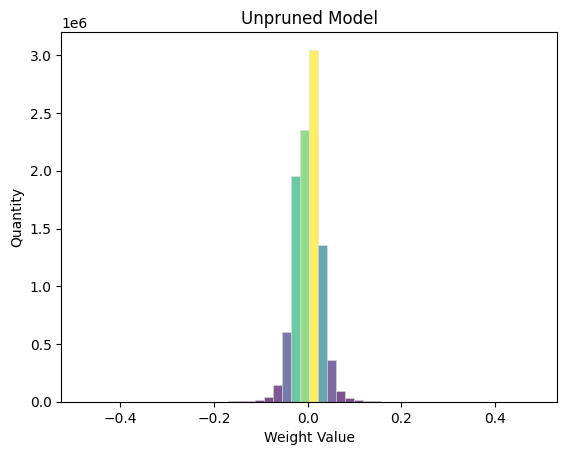

In [88]:
plot_graphs(final_t_pruned,title="Unpruned Model",magnitude=False)

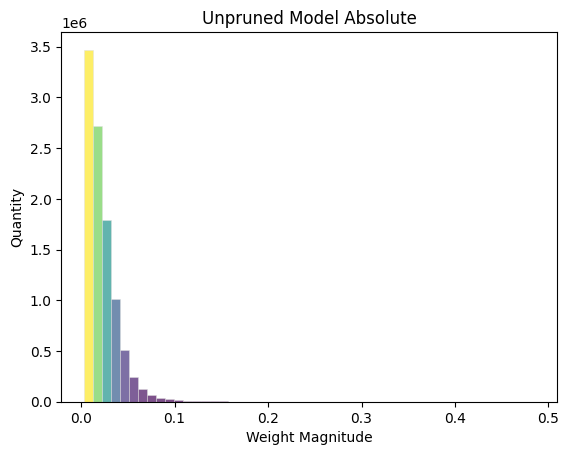

In [89]:
plot_graphs(abs_vals_pruned,title= "Unpruned Model Absolute")

# **L1 Unstructured Pruning**

## **30% Pruning**

In [57]:
final_t_pruned,abs_vals_pruned = prune(batch_size=32,method = "global",prune_percentage=0.3,prune_method="l1")

Total Trainable Params: 11179077
Percentage 0.3
Global Sparsity After pruning:
0.30
Per class Accuracy on Test Dataset from the Pruned model with pruning method l1 and sparsity 30.0
tensor([0.9310, 0.8900, 0.6380, 0.7060, 0.5560])


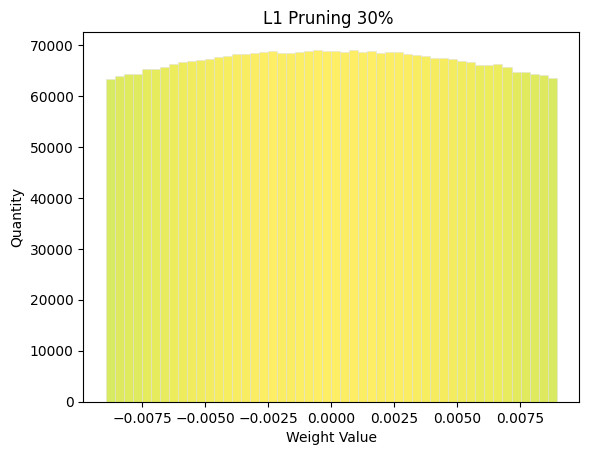

In [58]:
plot_graphs(final_t_pruned,title="L1 Pruning 30% ",magnitude=False)

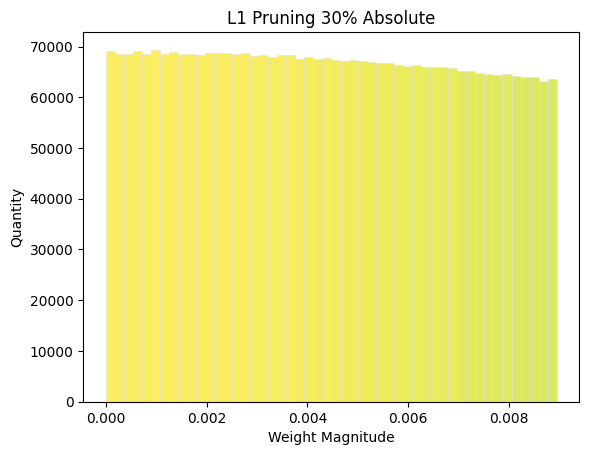

In [59]:
plot_graphs(abs_vals_pruned,title= "L1 Pruning 30% Absolute")

## **50% Pruning**

In [60]:
final_t_pruned,abs_vals_pruned = prune(batch_size=32,method = "global",prune_percentage=0.5,prune_method="l1")

Total Trainable Params: 11179077
Percentage 0.5
Global Sparsity After pruning:
0.50
Per class Accuracy on Test Dataset from the Pruned model with pruning method l1 and sparsity 50.0
tensor([0.9450, 0.8460, 0.7000, 0.6420, 0.4520])


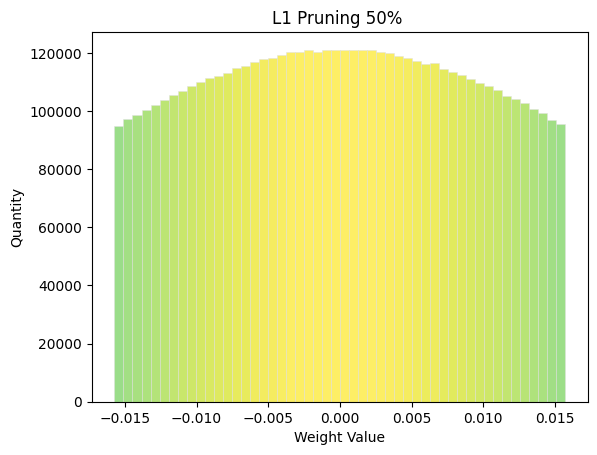

In [61]:
plot_graphs(final_t_pruned,title="L1 Pruning 50% ",magnitude=False)

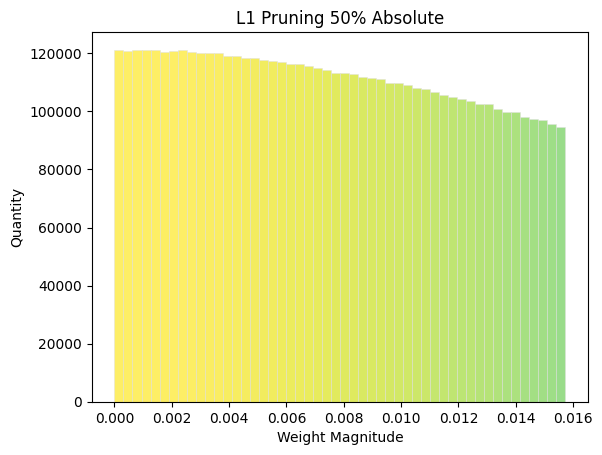

In [62]:
plot_graphs(abs_vals_pruned,title= "L1 Pruning 50% Absolute")

## **70% Pruning**

In [63]:
final_t_pruned,abs_vals_pruned = prune(batch_size=32,method = "global",prune_percentage=0.7,prune_method="l1")

Total Trainable Params: 11179077
Percentage 0.7
Global Sparsity After pruning:
0.70
Per class Accuracy on Test Dataset from the Pruned model with pruning method l1 and sparsity 70.0
tensor([0.9770, 0.5740, 0.5660, 0.5690, 0.4720])


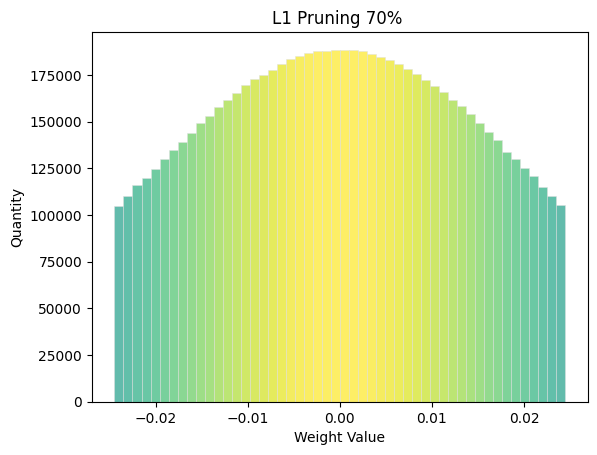

In [64]:
plot_graphs(final_t_pruned,title="L1 Pruning 70% ",magnitude=False)

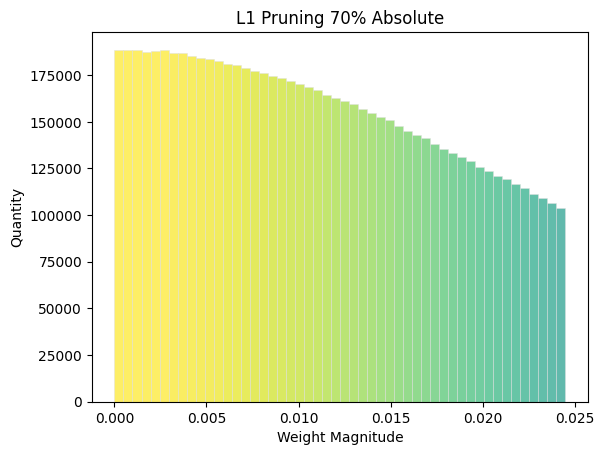

In [65]:
plot_graphs(abs_vals_pruned,title= "L1 Pruning 70% Absolute")

## **90% Pruning**

In [66]:
final_t_pruned,abs_vals_pruned = prune(batch_size=32,method = "global",prune_percentage=0.9,prune_method="l1")

Total Trainable Params: 11179077
Percentage 0.9
Global Sparsity After pruning:
0.90
Per class Accuracy on Test Dataset from the Pruned model with pruning method l1 and sparsity 90.0
tensor([0.9990, 0.0000, 0.0260, 0.0140, 0.0000])


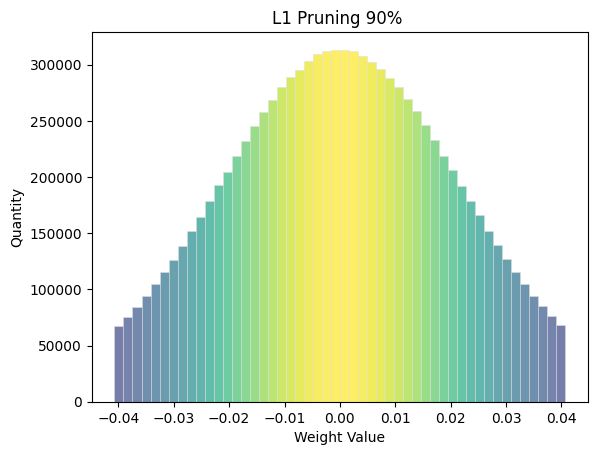

In [67]:
plot_graphs(final_t_pruned,title="L1 Pruning 90% ",magnitude=False)

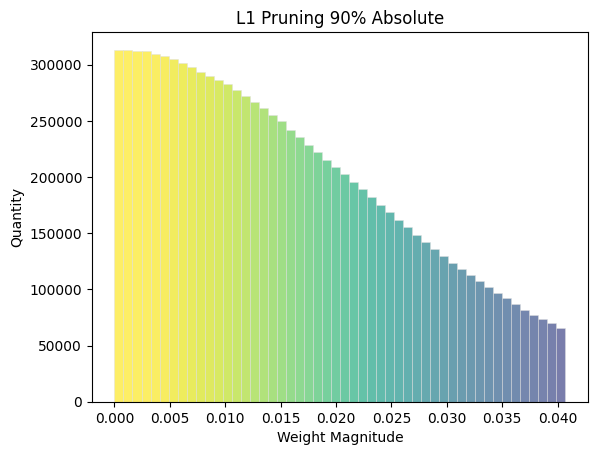

In [68]:
plot_graphs(abs_vals_pruned,title= "L1 Pruning 90% Absolute")

# **Custom Pruning**

## **30% Pruning**

In [69]:
final_t_pruned,abs_vals_pruned = prune(batch_size=32,method = "global",prune_percentage=0.3,prune_method="custom")

Total Trainable Params: 11179077
Percentage 0.3
Global Sparsity After pruning:
0.30
Per class Accuracy on Test Dataset from the Pruned model with pruning method custom and sparsity 30.0
tensor([1., 0., 0., 0., 0.])


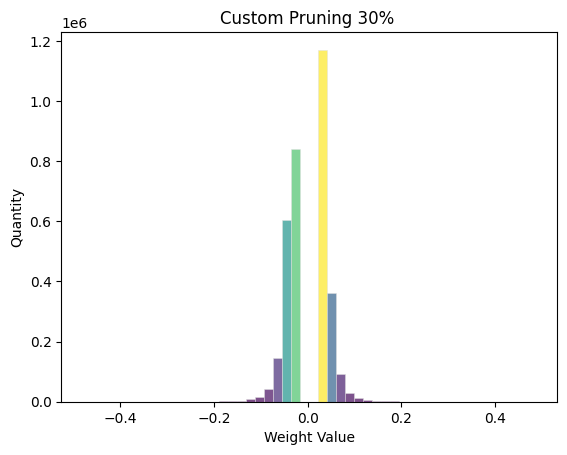

In [71]:
plot_graphs(final_t_pruned,title="Custom Pruning 30% ",magnitude=False)

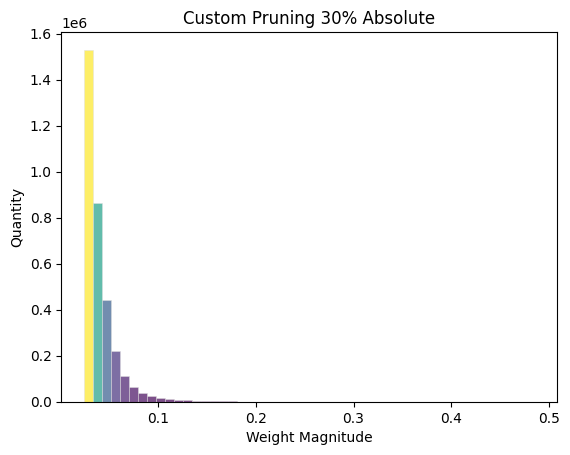

In [72]:
plot_graphs(abs_vals_pruned,title= "Custom Pruning 30% Absolute")

## **50% Pruning**

In [73]:
final_t_pruned,abs_vals_pruned = prune(batch_size=32,method = "global",prune_percentage=0.5,prune_method="custom")

Total Trainable Params: 11179077
Percentage 0.5
Global Sparsity After pruning:
0.50
Per class Accuracy on Test Dataset from the Pruned model with pruning method custom and sparsity 50.0
tensor([1., 0., 0., 0., 0.])


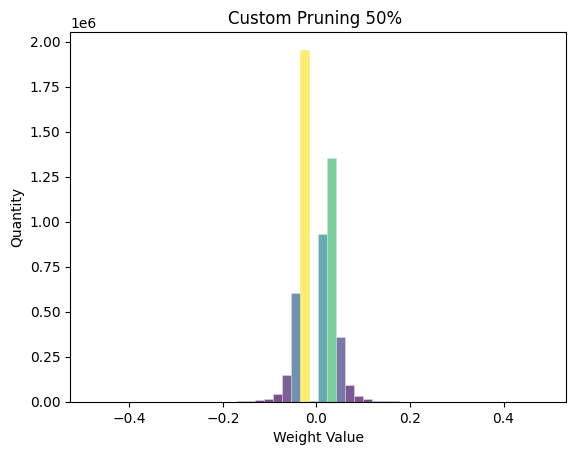

In [74]:
plot_graphs(final_t_pruned,title="Custom Pruning 50% ",magnitude=False)

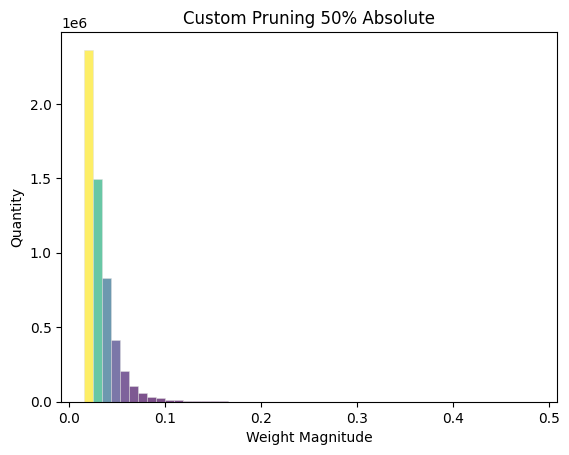

In [75]:
plot_graphs(abs_vals_pruned,title= "Custom Pruning 50% Absolute")

## **70% Pruning**

In [76]:
final_t_pruned,abs_vals_pruned = prune(batch_size=32,method = "global",prune_percentage=0.7,prune_method="custom")

Total Trainable Params: 11179077
Percentage 0.7
Global Sparsity After pruning:
0.70
Per class Accuracy on Test Dataset from the Pruned model with pruning method custom and sparsity 70.0
tensor([0., 0., 1., 0., 0.])


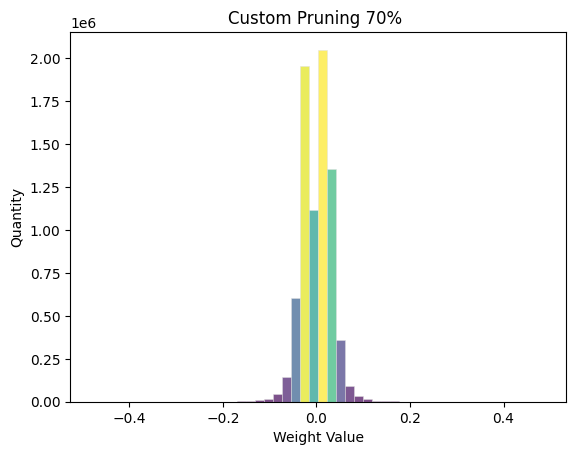

In [77]:
plot_graphs(final_t_pruned,title="Custom Pruning 70% ",magnitude=False)

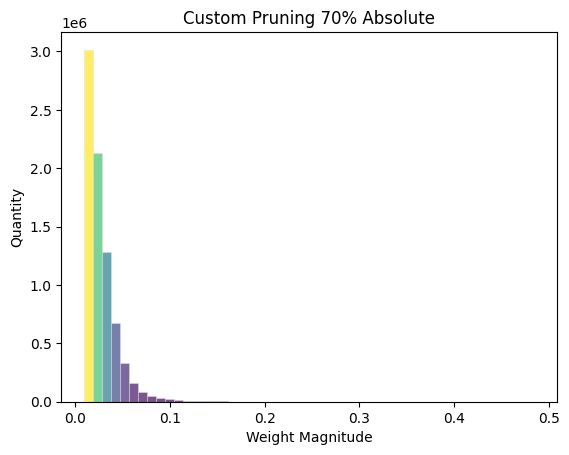

In [78]:
plot_graphs(abs_vals_pruned,title="Custom Pruning 70% Absolute")

## **90% Pruning**

In [79]:
final_t_pruned,abs_vals_pruned = prune(batch_size=32,method = "global",prune_percentage=0.9,prune_method="custom")

Total Trainable Params: 11179077
Percentage 0.9
Global Sparsity After pruning:
0.90
Per class Accuracy on Test Dataset from the Pruned model with pruning method custom and sparsity 90.0
tensor([1., 0., 0., 0., 0.])


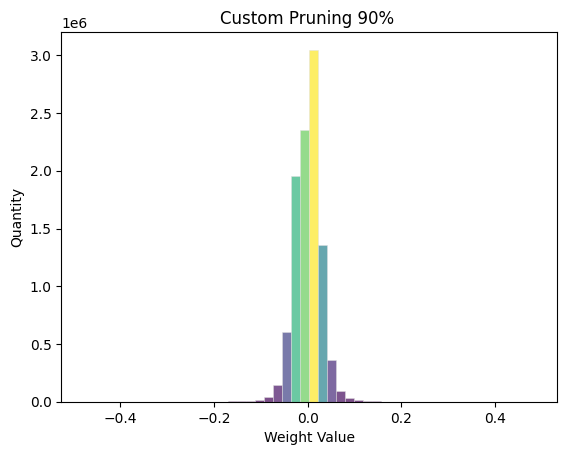

In [80]:
plot_graphs(final_t_pruned,title="Custom Pruning 90% ",magnitude=False)

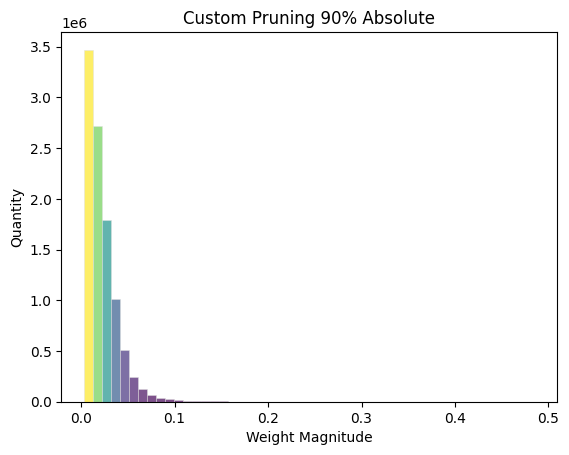

In [81]:
plot_graphs(abs_vals_pruned,title="Custom Pruning 90% Absolute")